In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from astropy.io import fits 
from astropy.table import Table
#not used today but lets check you have them
#import pandas

Explore a (very) small set of eBOSS data.
eBOSS data is located in what is called spPlates files. For a full description of the spPlates look https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/PLATE4/spPlate.html
Lets download one of this files.

In [2]:
url_file='https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3587/spPlate-3587-55182.fits'
plates_local='./spPlates/'
plate_file='spPlate-3588-55184.fits'
if not os.path.exists(plates_local):
        os.makedirs(plates_local)

local_file=plates_local+plate_file
if not os.path.exists(local_file):
    print("downloading spplate from %s to %s"
              % (url_file, local_file))
    tmp = urllib.request.urlretrieve(url_file, local_file)
else:
    print('%s  %s present on disk. '%(url_file,local_file))


downloading spplate from https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3587/spPlate-3587-55182.fits to ./spPlates/spPlate-3588-55184.fits


For documentation on how to manipulate, work with fits files see: https://docs.astropy.org/en/stable/io/fits/

FITS (Flexible Image Transport System). Standard format of files widely used in astronomy. 

In [19]:
#Explore the file we've just downloaded
file=plates_local+plate_file
plate1=fits.open(file)

In [20]:
plate1.info()

Filename: ./spPlates/spPlate-3588-55184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     209   (4627, 1000)   float32   
  1  IVAR          1 ImageHDU        16   (4627, 1000)   float32   
  2  ANDMASK       1 ImageHDU        15   (4627, 1000)   int32   
  3  ORMASK        1 ImageHDU        15   (4627, 1000)   int32   
  4  WAVEDISP      1 ImageHDU        16   (4627, 1000)   float32   
  5  PLUGMAP       1 BinTableHDU     88   1000R x 35C   [5J, 6A, D, D, 5E, E, E, E, 16A, D, D, J, J, J, J, J, J, E, 21A, E, E, J, K, K, K, K, J, 4A, J, J, J, 5E, 5E, 5J, E]   
  6  SKY           1 ImageHDU         8   (4627, 1000)   float32   


In [22]:
#What is in the PLUGMAP?
plugmap=plate1['PLUGMAP'].data
print(plugmap.columns)
Table(plugmap[:10])

ColDefs(
    name = 'OBJID'; format = '5J'
    name = 'HOLETYPE'; format = '6A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'MAG'; format = '5E'
    name = 'STARL'; format = 'E'
    name = 'EXPL'; format = 'E'
    name = 'DEVAUCL'; format = 'E'
    name = 'OBJTYPE'; format = '16A'
    name = 'XFOCAL'; format = 'D'
    name = 'YFOCAL'; format = 'D'
    name = 'SPECTROGRAPHID'; format = 'J'
    name = 'FIBERID'; format = 'J'
    name = 'THROUGHPUT'; format = 'J'
    name = 'PRIMTARGET'; format = 'J'
    name = 'SECTARGET'; format = 'J'
    name = 'OFFSETID'; format = 'J'
    name = 'SCI_EXPTIME'; format = 'E'
    name = 'SOURCETYPE'; format = '21A'
    name = 'LAMBDA_EFF'; format = 'E'
    name = 'ZOFFSET'; format = 'E'
    name = 'BLUEFIBER'; format = 'J'
    name = 'BOSS_TARGET1'; format = 'K'
    name = 'BOSS_TARGET2'; format = 'K'
    name = 'ANCILLARY_TARGET1'; format = 'K'
    name = 'ANCILLARY_TARGET2'; format = 'K'
    name = 'RUN'; format = 'J'
    na

OBJID [5],HOLETYPE,RA,DEC,MAG [5],STARL,EXPL,DEVAUCL,OBJTYPE,XFOCAL,YFOCAL,SPECTROGRAPHID,FIBERID,THROUGHPUT,PRIMTARGET,SECTARGET,OFFSETID,SCI_EXPTIME,SOURCETYPE,LAMBDA_EFF,ZOFFSET,BLUEFIBER,BOSS_TARGET1,BOSS_TARGET2,ANCILLARY_TARGET1,ANCILLARY_TARGET2,RUN,RERUN,CAMCOL,FIELD,ID,CALIBFLUX [5],CALIBFLUX_IVAR [5],CALIB_STATUS [5],SFD_EBV
int32,str6,float64,float64,float32,float32,float32,float32,str16,float64,float64,int32,int32,int32,int32,int32,int32,float32,str21,float32,float32,int32,int64,int64,int64,int64,int32,str4,int32,int32,int32,float32,float32,int32,float32
4263 .. 555,OBJECT,10.370096999999987,-0.32742256,24.104 .. 20.5558,0.0,0.0,0.0,GALAXY,298.73532,-71.390202,1,1,30959,0,0,1,0.0,LRG,5400.0,0.0,0,14,0,0,0,4263,301,3,185,555,0.30864716 .. 12.513989,9.171619 .. 0.39530864,24577 .. 24577,0.017130649
0 .. 0,OBJECT,10.394055999999978,-0.4312578,0.0 .. 0.0,0.0,0.0,0.0,SKY,304.04866,-94.059437,1,2,42655,0,0,1,0.0,NA,5400.0,0.0,1,0,0,0,0,0,,0,0,0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0.018628633
4263 .. 1092,OBJECT,10.421029999999973,0.17154846,24.1131 .. 21.0,0.0,0.0,0.0,GALAXY,309.88309,37.412404,1,3,26984,0,0,1,0.0,LRG,5400.0,0.0,0,6,0,0,0,4263,301,4,185,1092,0.30577248 .. 8.141251,7.7433157 .. 0.3502765,24577 .. 24577,0.021023309
4263 .. 913,OBJECT,10.46011599999997,0.092327232,23.6598 .. 20.6133,0.0,0.0,0.0,GALAXY,318.47029,20.140509,1,4,38700,0,0,1,0.0,LRG,5400.0,0.0,0,14,0,0,0,4263,301,4,185,913,0.6212466 .. 11.857936,7.603021 .. 0.33864444,24577 .. 24577,0.021203976
2677 .. 379,OBJECT,10.333602999999982,-0.45992123,23.2809 .. 19.4427,0.0,0.0,0.0,GALAXY,290.77827,-100.28127,1,5,39397,0,0,1,0.0,LRG,5400.0,0.0,0,9,0,0,0,2677,301,2,45,379,0.9676229 .. 34.876152,3.470182 .. 0.22033964,1 .. 24577,0.018770812
2728 .. 661,OBJECT,10.38509799999997,-0.019214451,23.7809 .. 21.5824,0.0,0.0,0.0,QSO,301.97071,-4.1589202,1,6,25818,0,0,1,0.0,QSO,4000.0,0.0,1,65536,0,0,0,2728,301,3,482,661,0.66565907 .. 3.9813192,15.529759 .. 1.6063005,24577 .. 24577,0.021647435
4263 .. 705,OBJECT,10.41696300000001,-0.41859036,24.3777 .. 19.8348,0.0,0.0,0.0,GALAXY,309.08296,-91.307996,1,7,36238,0,0,1,0.0,LRG,5400.0,0.0,0,41,0,0,0,4263,301,3,185,705,0.14567119 .. 24.574926,9.214337 .. 0.36851755,24577 .. 24577,0.01834976
4263 .. 488,OBJECT,10.35045500000001,-0.3339195,24.441 .. 20.0421,0.0,0.0,0.0,GALAXY,294.4252,-72.799906,1,8,38007,0,0,1,0.0,LRG,5400.0,0.0,0,14,0,0,0,4263,301,3,185,488,0.108290136 .. 20.285334,9.637888 .. 0.36500335,24577 .. 24577,0.017427176
4263 .. 764,OBJECT,10.414154999999994,0.19465718,23.5114 .. 20.5401,0.0,0.0,0.0,GALAXY,308.37661,42.450793,1,9,33384,0,0,1,0.0,LRG,5400.0,0.0,0,6,0,0,0,4263,301,4,185,764,0.73155016 .. 12.753761,5.1192884 .. 0.33748725,24577 .. 24577,0.020741949


In [23]:
#As you can see an spPlate has different types of objects. Which types? 
print(np.unique(plugmap['OBJTYPE']))

['GALAXY' 'NA' 'QSO' 'SKY' 'SPECTROPHOTO_STD']


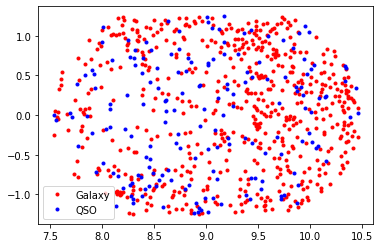

In [24]:
#Lets look at the distribution of Galaxies in the sky. 
wg=plugmap['OBJTYPE']=='GALAXY'
wq=plugmap['OBJTYPE']=='QSO'
plt.plot(plugmap['RA'][wg],plugmap['DEC'][wg],'.',color='r',label='Galaxy')
plt.plot(plugmap['RA'][wq],plugmap['DEC'][wq],'.',color='b',label='QSO')
plt.legend()

So lets get the observed flux, and see how the spectra looks like.
The wavelenght is given by the parameters 'COEFF0' and 'COEFF1' present in the header of the first hdu of the spPlate file, while the flux is an array in the same hdu.

In [26]:
#Get the wavelenght
pltheader=plate1[0].header
coeff0=pltheader['COEFF0']
coeff1=pltheader['COEFF1']
objtype=plugmap['OBJTYPE']
fiberid_pm=plugmap['FIBERID']
flux=plate1[0].data
ivar=plate1[1].data

logwave=coeff0+coeff1*np.arange(flux.shape[1])


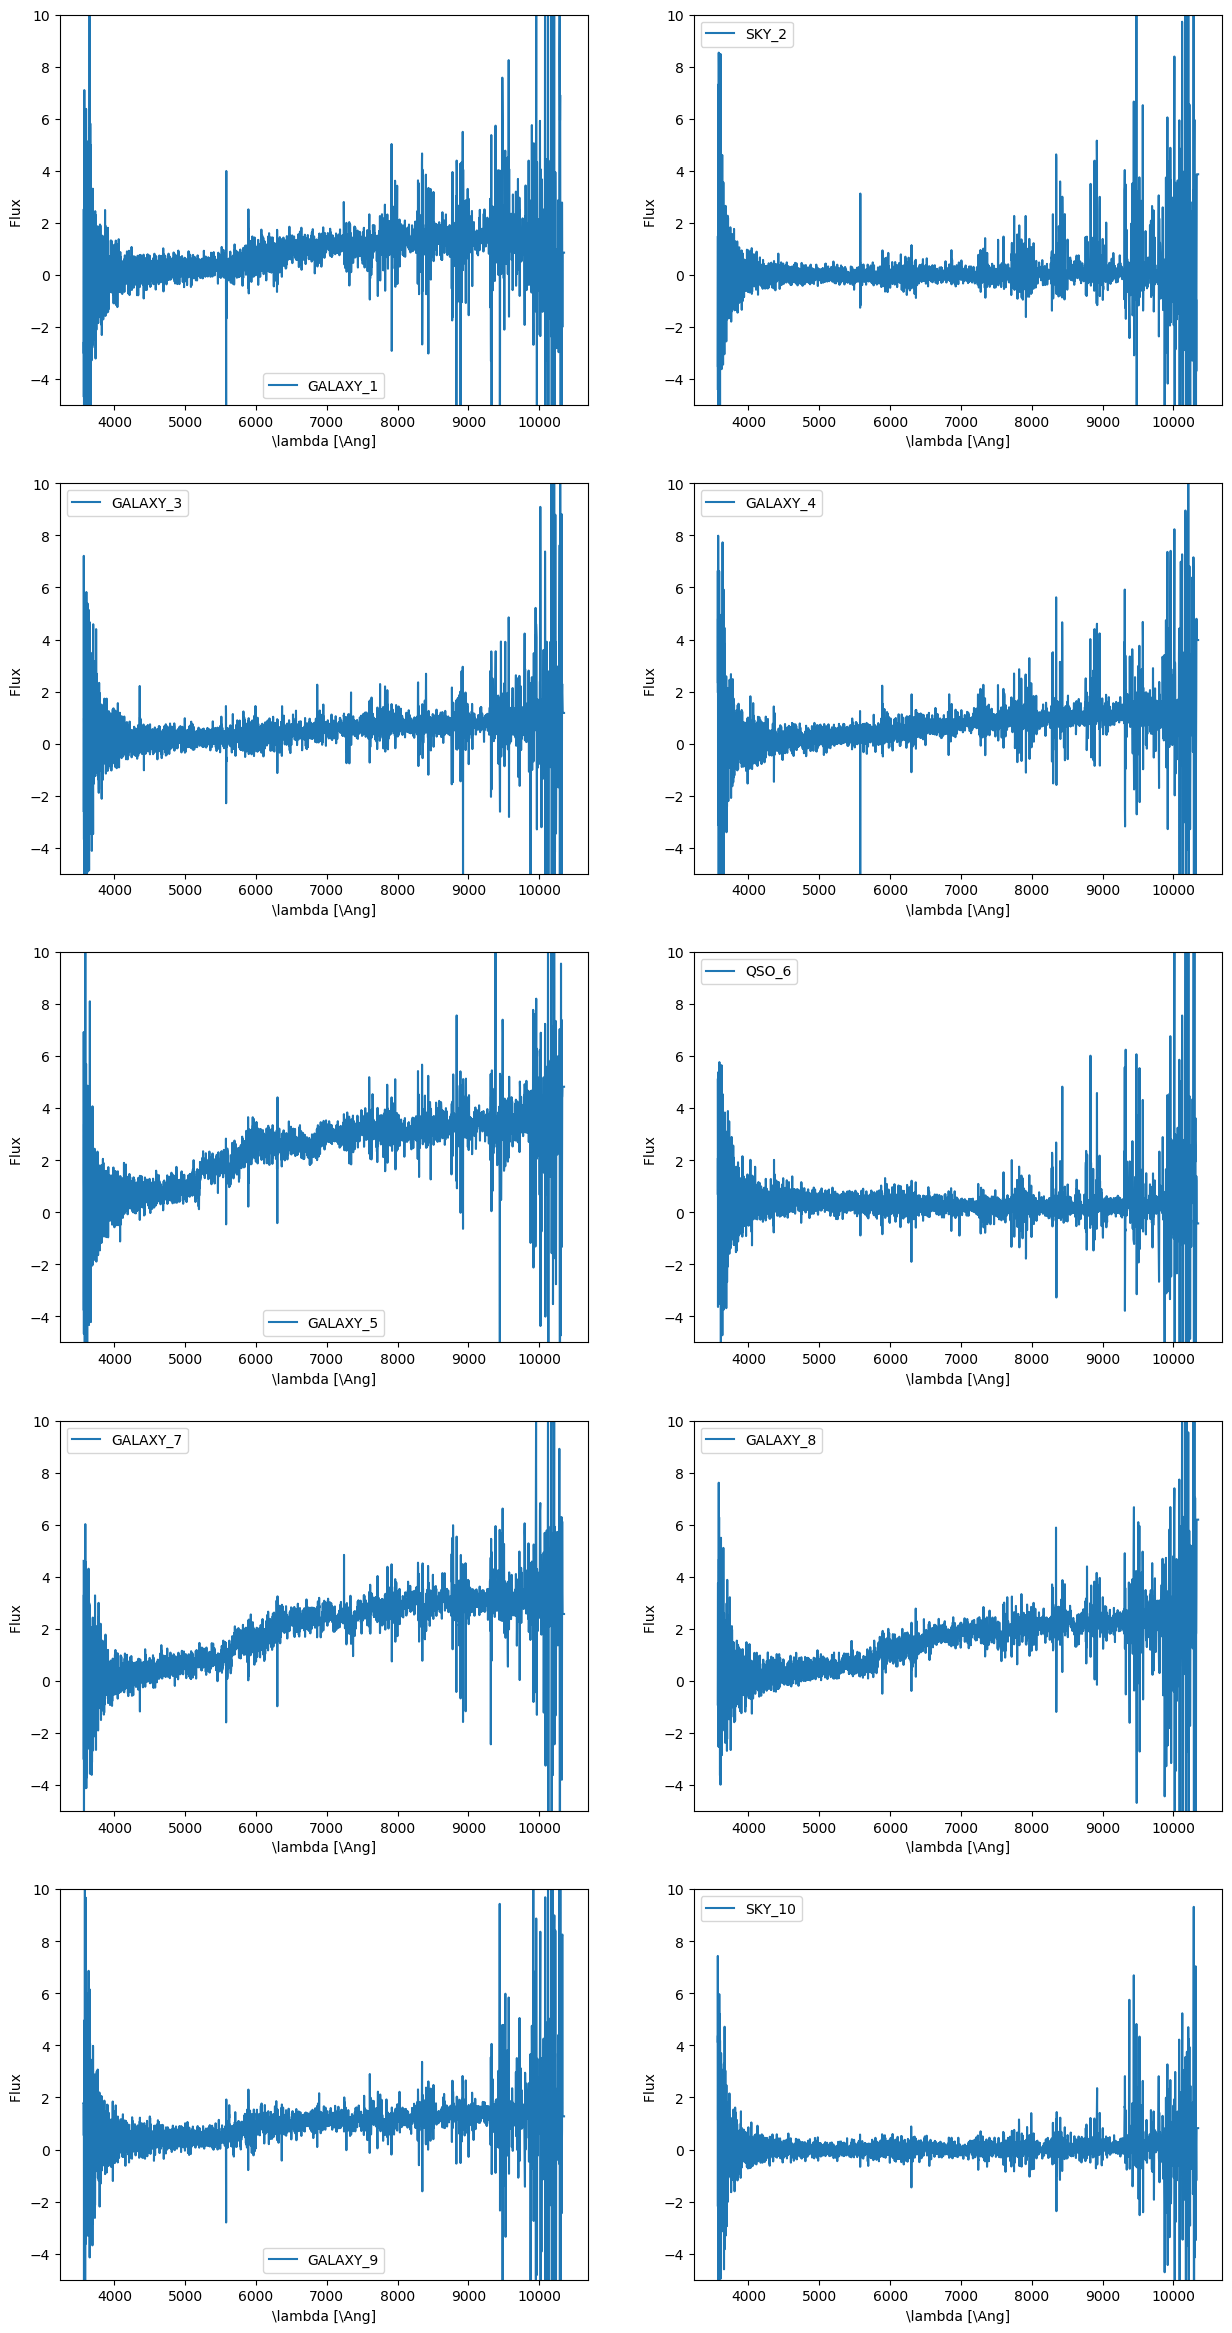

In [36]:
#Plot some of the specta
plt.figure(figsize=(15,30),dpi=100)
i=0
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(10**logwave,flux[fiberid_pm[i]-1],label=objtype[i]+'_'+str(fiberid_pm[i]))
   # print(ids_[i],zqso_[i])
    plt.ylabel('Flux ') #Units 1E-17 erg/cm^2/s/Ang
    plt.xlabel('\lambda [\Ang]')
    plt.ylim(-5,10)
    plt.legend()

In [28]:
#Lets see only quasars. 
fiberid_qso=fiberid_pm[wq]

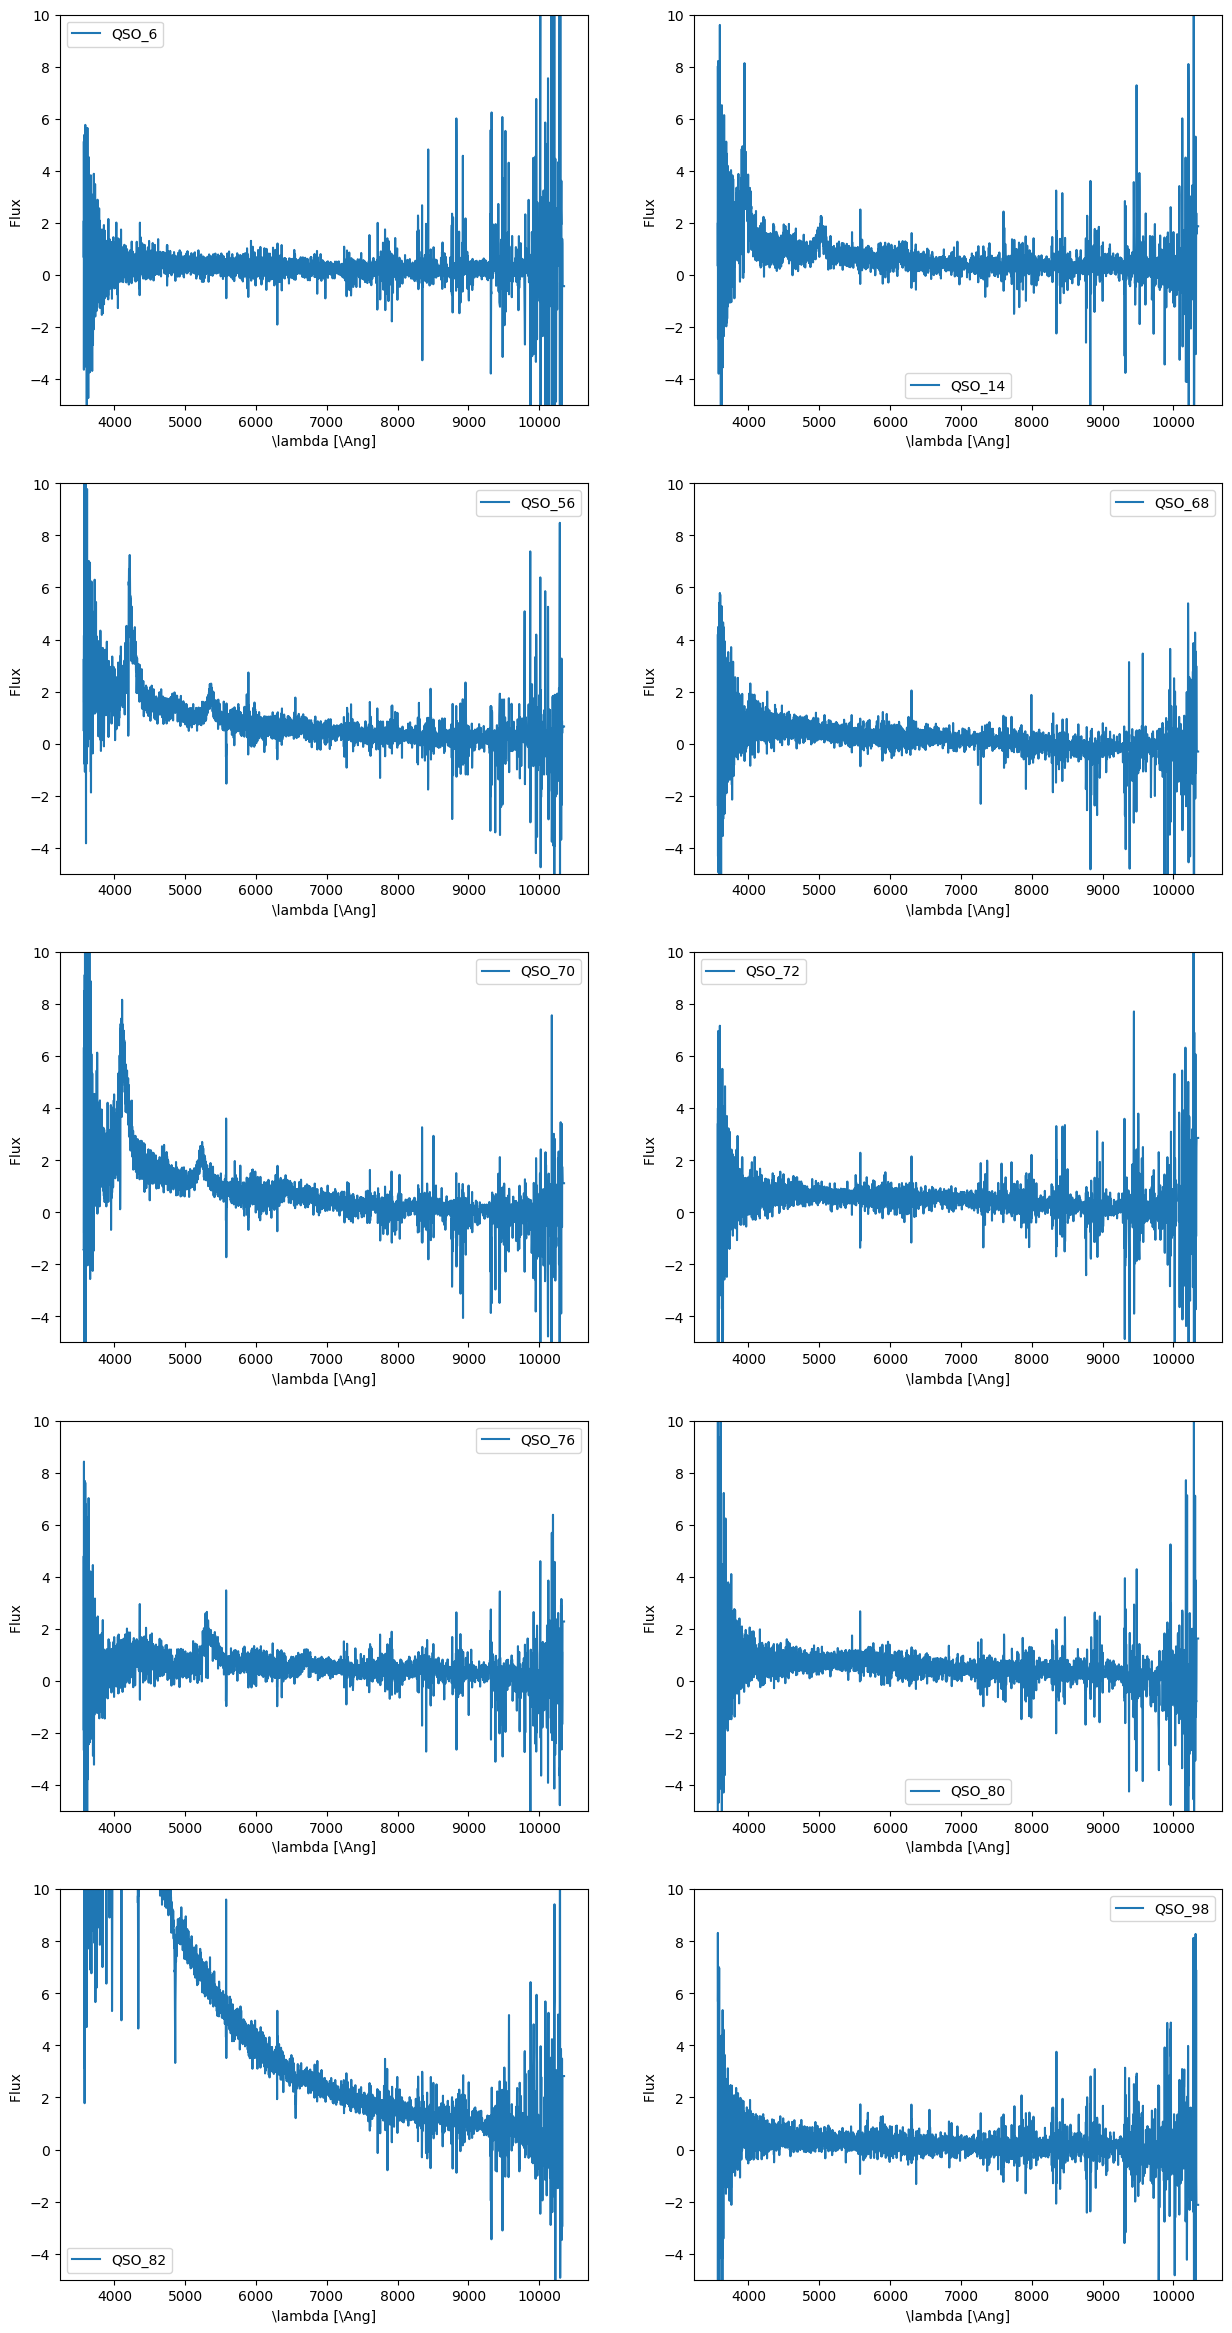

In [37]:
#Plot some of the specta
plt.figure(figsize=(15,30),dpi=100)
i=0
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(10**logwave,flux[fiberid_qso[i]-1],label=objtype[fiberid_qso[i]-1]+'_'+str(fiberid_qso[i]))
#    print(fiberid_qso[i]-1)
    plt.ylabel('Flux ') #Units 1E-17 erg/cm^2/s/Ang
    plt.xlabel('\lambda [\Ang]')
    plt.ylim(-5,10)
    plt.legend()

In [40]:
#Not all quasars in these files are good for science, only those that made it to the oficial DR14 qso catalog
DATA_URL="https://data.sdss.org/sas/dr14/eboss/qso/DR14Q/"
file="DR14Q_v4_4.fits"
local_dir="./"
local_file = os.path.join(local_dir,file)
if not os.path.exists(file):
        print("downloading DR14 quasar dataset from %s to %s"
              % (DATA_URL+file, local_file ))
        tmp = urllib.request.urlretrieve(DATA_URL+local_file, local_file)
        print ("Downloaded file"+local_file)
else:
    print("%s already exist"%(local_file))

downloading DR14 quasar dataset from https://data.sdss.org/sas/dr14/eboss/qso/DR14Q/DR14Q_v4_4.fits to ./DR14Q_v4_4.fits
Downloaded file./DR14Q_v4_4.fits


In [41]:
catalog=Table.read('DR14Q_v4_4.fits')
cat=catalog[(catalog['MJD']==55184) & (catalog['PLATE']==3588)]
cat.sort('PLATE')
fiberid_cat=cat['FIBERID']

In [43]:
catalog[:10]

SDSS_NAME,RA,DEC,THING_ID,PLATE,MJD,FIBERID,SPECTRO,Z,Z_ERR,SOURCE_Z,Z_VI,Z_PIPE,Z_PIPE_ERR,ZWARNING,Z_PCA,Z_PCA_ER,Z_MGII,BOSS_TARGET1,ANCILLARY_TARGET1,ANCILLARY_TARGET2,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,N_SPEC_SDSS,N_SPEC_BOSS,N_SPEC,PLATE_DUPLICATE [51],MJD_DUPLICATE [51],FIBERID_DUPLICATE [51],SPECTRO_DUPLICATE [51],BI_CIV,ERR_BI_CIV,RUN_NUMBER,RERUN_NUMBER,COL_NUMBER,FIELD_NUMBER,OBJ_ID,PSFFLUX [5],IVAR_PSFFLUX [5],PSFMAG [5],ERR_PSFMAG [5],MI,GAL_EXT [5],RASS_COUNTS,RASS_COUNTS_SNR,SDSS2ROSAT_SEP,FLUX_0.2_2.0keV,FLUX_0.2_2.0keV_ERR,FLUX_2.0_12.0keV,FLUX_2.0_12.0keV_ERR,FLUX_0.2_12.0keV,FLUX_0.2_12.0keV_ERR,LUM_0.2_12.0keV,SDSS2XMM_SEP,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,JMAG,ERR_JMAG,JSNR,JRDFLAG,HMAG,ERR_HMAG,HSNR,HRDFLAG,KMAG,ERR_KMAG,KSNR,KRDFLAG,SDSS2MASS_SEP,W1MAG,ERR_W1MAG,W1SNR,W1CHI2,W2MAG,ERR_W2MAG,W2SNR,W2CHI2,W3MAG,ERR_W3MAG,W3SNR,W3CHI2,W4MAG,ERR_W4MAG,W4SNR,W4CHI2,CC_FLAGS,PH_FLAGS,SDSS2WISE_SEP,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP
-,deg,deg,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,km / s,km / s,-,-,-,-,-,nanomaggies,-,mag,mag,-,mag,counts/s,-,arcsec,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / s,arcsec,-,-,-,-,-,Vega,Vega,-,-,Vega,Vega,-,-,Vega,Vega,-,-,arcsec,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,arcsec,-,W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),-,mJy,-,arcsec
bytes18,float64,float64,int32,int16,int32,int16,bytes4,float64,float64,bytes4,float64,float64,float64,int16,float64,float64,float64,int64,int64,int64,int64,int64,int64,int16,int16,int16,int32,int32,int32,bytes1,float64,float64,int16,bytes1,int16,int16,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes4,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64
000000.45+174625.4,0.001898274356335605,17.773739123771385,268270422,7596,56945,162,BOSS,2.309,0.0,VI,2.309000015258789,2.307750701904297,0.0010300044668838382,0,2.3045657000000004,-1.0,-1.0,0,0,0,0,4096,0,0,1,1,0 .. -1,0 .. -1,0 .. -1,- .. -,0.0,0.0,0,-,0,0,-,1.0379366874694824 .. 2.631136417388916,12.372532844543457 .. 0.8706143498420715,22.440338134765625 .. 21.372461318969727,0.2871243953704834 .. 0.38545534014701843,-24.410782,0.12021728605031967 .. 0.03581845760345459,0.0,0.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.30231887102127075,8.785573140381722,0.7275648713111877,4.537358964921044,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1.0,-1.0,-1.0
000000.57+055630.8,0.0023754761888312714,5.941903005523435,163544156,8740,57367,694,BOSS,2.1031202999999996,0.0,AUTO,-1.0,2.1031203269958496,0.0009241577354259787,0,2.0996384999999997,2.0983490000000002,2.0983490000000002,0,0,0,0,2048,0,0,0,0,-1 .. -1,-1 .. -1,-1 .. -1,- .. -,0.0,0.0,0,-,0,0,-,1.1197296380996704 .. 4.730101585388184,9.196866035461426 .. 0.8192309737205505,22.360628128051758 .. 20.78717613220215,0.3101848363876343 .. 0.2420300394296646,-24.732,0.2338263988494873 .. 0.06966802477836609,0.0,0.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,0.0,0.0,0.0,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,-1,nan,16.969,0.127,8.5,0.9904,16.887999999999998,0.409,2.700000047683716,1.004,11.861,nan,1.399999976158142,0.9819,8.604,0.127,0.699999988079071,0.9478,hH00,BCUU,0.706171,1.0,1.2885136657753169e-31,2.4790984841010035e-32,1.229889058862803e-31,4.504542253745802e-32,1.496424644649041e-31,4.7290496259357616

In [45]:
Look at the quasars 
cat

SDSS_NAME,RA,DEC,THING_ID,PLATE,MJD,FIBERID,SPECTRO,Z,Z_ERR,SOURCE_Z,Z_VI,Z_PIPE,Z_PIPE_ERR,ZWARNING,Z_PCA,Z_PCA_ER,Z_MGII,BOSS_TARGET1,ANCILLARY_TARGET1,ANCILLARY_TARGET2,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,N_SPEC_SDSS,N_SPEC_BOSS,N_SPEC,PLATE_DUPLICATE [51],MJD_DUPLICATE [51],FIBERID_DUPLICATE [51],SPECTRO_DUPLICATE [51],BI_CIV,ERR_BI_CIV,RUN_NUMBER,RERUN_NUMBER,COL_NUMBER,FIELD_NUMBER,OBJ_ID,PSFFLUX [5],IVAR_PSFFLUX [5],PSFMAG [5],ERR_PSFMAG [5],MI,GAL_EXT [5],RASS_COUNTS,RASS_COUNTS_SNR,SDSS2ROSAT_SEP,FLUX_0.2_2.0keV,FLUX_0.2_2.0keV_ERR,FLUX_2.0_12.0keV,FLUX_2.0_12.0keV_ERR,FLUX_0.2_12.0keV,FLUX_0.2_12.0keV_ERR,LUM_0.2_12.0keV,SDSS2XMM_SEP,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,JMAG,ERR_JMAG,JSNR,JRDFLAG,HMAG,ERR_HMAG,HSNR,HRDFLAG,KMAG,ERR_KMAG,KSNR,KRDFLAG,SDSS2MASS_SEP,W1MAG,ERR_W1MAG,W1SNR,W1CHI2,W2MAG,ERR_W2MAG,W2SNR,W2CHI2,W3MAG,ERR_W3MAG,W3SNR,W3CHI2,W4MAG,ERR_W4MAG,W4SNR,W4CHI2,CC_FLAGS,PH_FLAGS,SDSS2WISE_SEP,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP
-,deg,deg,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,km / s,km / s,-,-,-,-,-,nanomaggies,-,mag,mag,-,mag,counts/s,-,arcsec,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / s,arcsec,-,-,-,-,-,Vega,Vega,-,-,Vega,Vega,-,-,Vega,Vega,-,-,arcsec,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,arcsec,-,W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),-,mJy,-,arcsec
bytes18,float64,float64,int32,int16,int32,int16,bytes4,float64,float64,bytes4,float64,float64,float64,int16,float64,float64,float64,int64,int64,int64,int64,int64,int64,int16,int16,int16,int32,int32,int32,bytes1,float64,float64,int16,bytes1,int16,int16,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes4,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64
003426.23+002602.0,8.609296564138617,0.4338955257437757,106534928,3588,55184,510,BOSS,3.23,0.0,VI,3.2300000190734863,3.23108983039856,0.0006336775841191411,0,3.2148204,-1.0,-1.0,201728,0,0,0,0,0,1,1,2,0 .. -1,0 .. -1,0 .. -1,- .. -,0.0,0.0,0,-,0,0,-,0.02617514133453369 .. 7.913082122802734,44.65258026123047 .. 2.459162473678589,24.533329010009766 .. 20.244762420654297,0.5777681469917297 .. 0.08600404113531113,-26.673836,0.10057845711708069 .. 0.029967114329338074,0.0,0.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.04302794486284256,100.18372589635844,-0.022092310711741447,562.9884013675153,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,-1,nan,17.000999999999998,0.13,8.399999618530273,0.9504,16.099,0.219,5.0,0.9708,11.892,nan,1.100000023841858,0.8599,8.338,0.13,1.0,0.9139,0000,BBUU,0.856248,1.0,3.1930524341640286e-31,3.2466854218652116e-32,2.9909527467124658e-31,5.123221093630894e-32,3.3336638929150407e-31,5.434809968950535e-32,3.535358034815571e-31,5.869725246339519e-32,0,-1.0,-1.0,-1.0
003954.01+005737.5,9.975042169771145,0.9604300458760444,115829197,3588,55184,756,BOSS,0.68,0.0,VI,0.6800000071525574,0.6795452237129211,0.00016895026783458889,0,0.68120503,0.67971057,0.67971057,0,2048,0,0,0,0,0,2,2,0 .. -1,0 .. -1,0 .. -1,- .. -,0.0,0.0,0,-,0,0,-,2.1187846660614014 .. 9.253254890441895,20.540164947509766 .. 1.3700501918792725,21.680072784423828 .. 20.07738494873047,0.11209236085414886 .. 0.09898658841848373,-22.962467,0.08748368918895721 .. 0.026065560057759285,0.0,0.0,-1.0,6.142530000000001e-14,4.31837e-15,5.415880000000002e-14,1.7828389999999995e-14,1.16362e-13,1.52443e-14,2.4717246844170404e+44,0.28282333016635425,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan

In [46]:
#Find such quasars that are in the catalog and in the spPlate file we downloaded.
#We could also do it the other way around, select some quasars from the catalog, and then download the corresponing spPlates. 
fbid_incat=fiberid_qso[np.in1d(fiberid_qso,fiberid_cat)]

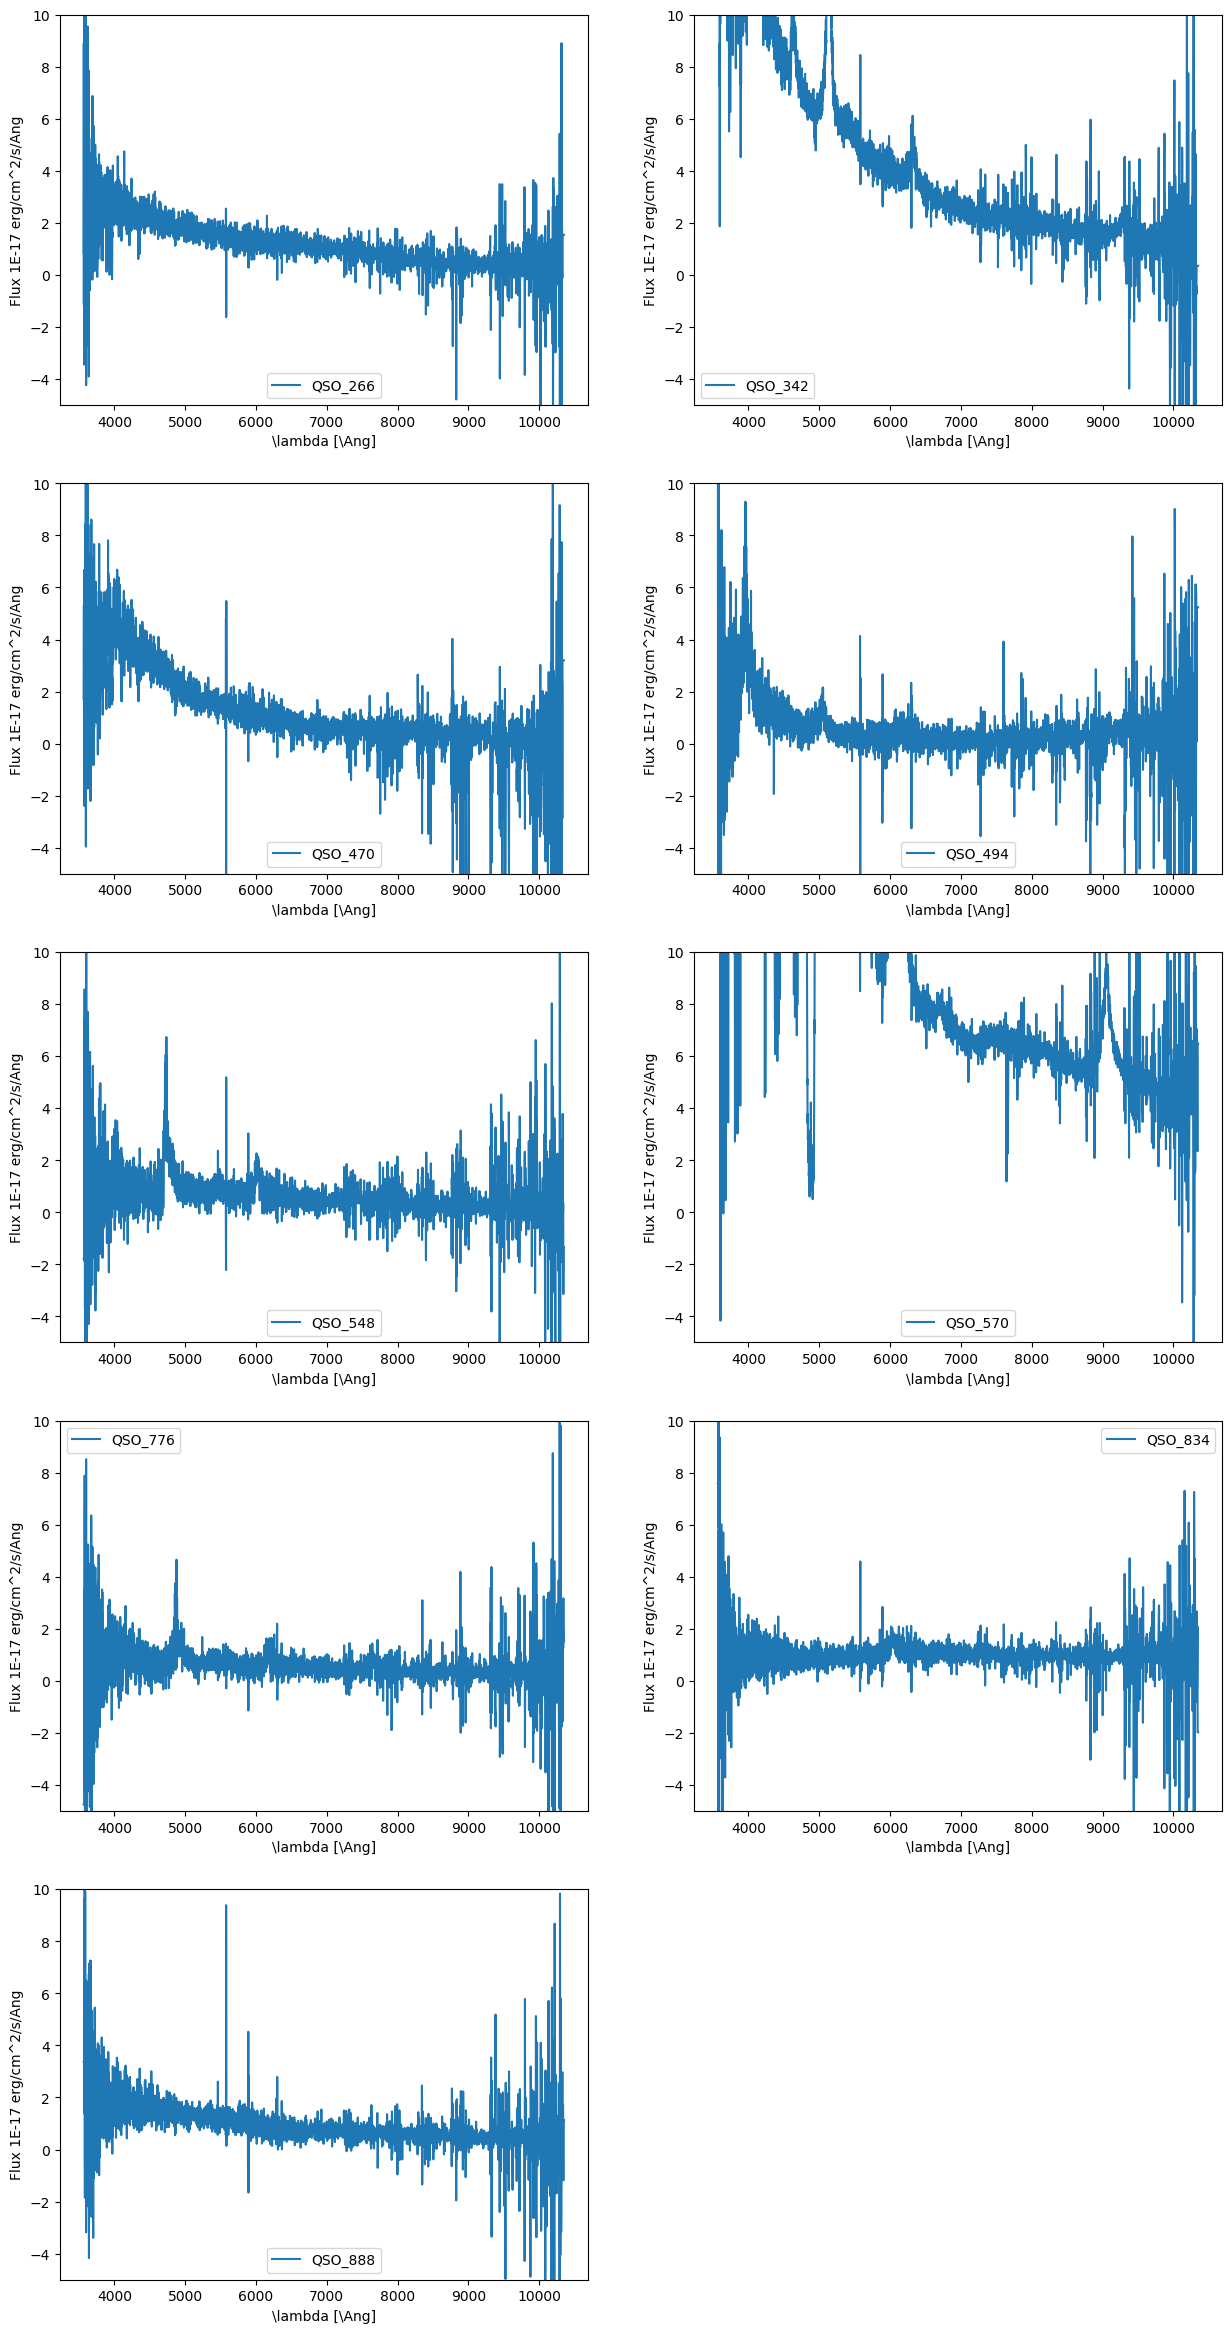

In [51]:
#Plot some of the specta
plt.figure(figsize=(15,30),dpi=100)
i=0
for i in range(9):
    plt.subplot(5,2,i+1)
    plt.plot(10**logwave,flux[fbid_incat[i]-1],label=objtype[fbid_incat[i]-1]+'_'+str(fbid_incat[i]))
    plt.ylabel('Flux 1E-17 erg/cm^2/s/Ang')
    plt.xlabel('\lambda [\Ang]')
    plt.ylim(-5,10)
    plt.legend()

## TO DO

- Change the wavelenght from the observed frame to the rest frame. Use $\lambda_{RF}=\lambda_{OBS}/(1+Z)$, where Z is the redshift. Plot the spectra and see if you can spot some common characteristics by eye. 

- Separate the quasars in those with z>2.1 and z< 2.1. 

  - Do a PCA for the spectra in each of the redshift ranges. Use the data ordered in the rest-frame. You can follow and adapt things from https://www.astroml.org/book_figures/chapter7/fig_spec_decompositions.html and https://www.astroml.org/book_figures_1ed/chapter7/fig_spec_reconstruction.html 

- Reconstruct the spectra used from the basis of eigenvectors found by the PCA, each spectrum can be described by  
$x_i(k)=\mu(k) \sum_j \theta_{ij} e_{j}(k)$ 

where $i$ corresponds with the spectra, $j$ is the eigen spectra, $k$ is the wavelenght in this case.
$\mu$ is the spectra mean and $\theta_{ij}$ are coeficients for the expansion in eigenvectors.